In [1]:
# import libraries 
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split


In [2]:
# import dataset 
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Path to dataset files:", path)


100%|██████████| 5.20G/5.20G [04:54<00:00, 19.0MB/s]  


Extracting files...
Path to dataset files: C:\Users\giamb\.cache\kagglehub\datasets\kmader\skin-cancer-mnist-ham10000\versions\2


In [3]:
import shutil

# Define the paths to the two folders
folder1 = os.path.join(path, 'HAM10000_images_part_1')
folder2 = os.path.join(path, 'HAM10000_images_part_2')
merged_folder = os.path.join(path, 'HAM10000_images_merged')

# Create the merged folder if it doesn't exist
if not os.path.exists(merged_folder):
    os.makedirs(merged_folder)

# Move all images from folder1 to merged_folder
for filename in os.listdir(folder1):
    shutil.move(os.path.join(folder1, filename), os.path.join(merged_folder, filename))

# Move all images from folder2 to merged_folder
for filename in os.listdir(folder2):
    shutil.move(os.path.join(folder2, filename), os.path.join(merged_folder, filename))

print("Images have been merged into:", merged_folder)

Images have been merged into: C:\Users\giamb\.cache\kagglehub\datasets\kmader\skin-cancer-mnist-ham10000\versions\2\HAM10000_images_merged


Number of images in the merged folder: 10015
No duplicate images found.


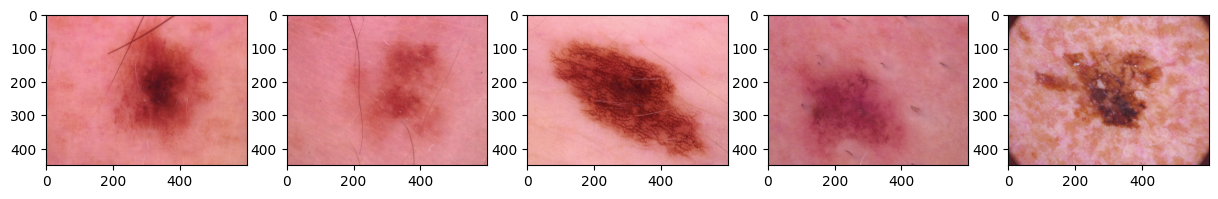

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter

# Define the path to the merged folder
merged_folder = os.path.join(path, 'HAM10000_images_merged')

# Count the number of images in the merged folder
image_files = [f for f in os.listdir(merged_folder) if os.path.isfile(os.path.join(merged_folder, f))]
print(f"Number of images in the merged folder: {len(image_files)}")

# Check for duplicate images
image_counts = Counter(image_files)
duplicates = [item for item, count in image_counts.items() if count > 1]
if duplicates:
    print(f"Found {len(duplicates)} duplicate images.")
else:
    print("No duplicate images found.")

# Display sample images
num_samples = 5
sample_images = image_files[:num_samples]
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for ax, img_file in zip(axes, sample_images):
    img_path = os.path.join(merged_folder, img_file)
    img = mpimg.imread(img_path)
    ax.imshow(img)

In [5]:
import pandas as pd
import os

# Define the path to the base folder where all images are placed
base_skin_dir = os.path.join(path, 'HAM10000_images_merged')

# Read the CSV file containing the metadata
metadata_path = os.path.join(path, 'HAM10000_metadata.csv')
df = pd.read_csv(metadata_path)

# Create the 'path' column by joining the base folder path with the image_id
df['path'] = df['image_id'].map(lambda x: os.path.join(base_skin_dir, f'{x}.jpg'))

# Create the 'cell_type' column with the short name of the lesion type
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df['cell_type'] = df['dx'].map(lesion_type_dict.get)

# Create the 'cell_type_idx' column by categorizing the lesion type into codes from 0 to 6
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

# Display the first few rows of the dataframe to verify the changes
print(df.head())

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  C:\Users\giamb\.cache\kagglehub\datasets\kmade...   
1  C:\Users\giamb\.cache\kagglehub\datasets\kmade...   
2  C:\Users\giamb\.cache\kagglehub\datasets\kmade...   
3  C:\Users\giamb\.cache\kagglehub\datasets\kmade...   
4  C:\Users\giamb\.cache\kagglehub\datasets\kmade...   

                       cell_type  cell_type_idx  
0  Benign keratosis-like lesions              2  
1  Benign keratosis-like lesions              2  
2  Benign keratosis-like lesions              2  
3  Benign keratosis-like lesions          

EXPLORATORY DATA ANALYSIS 

cell_type
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64


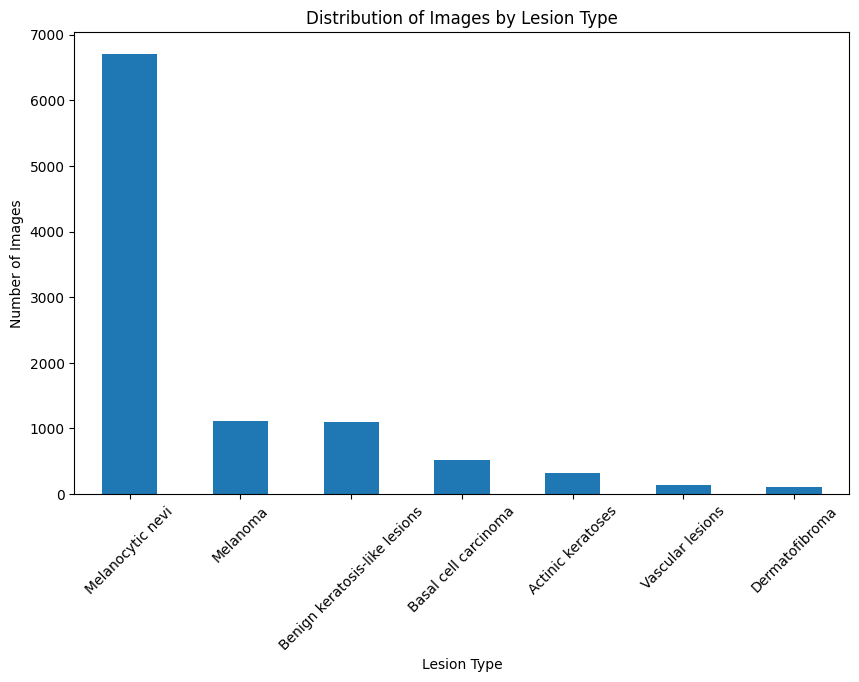

In [6]:
category_counts = df['cell_type'].value_counts()
print(category_counts)

# Plot the distribution of images for each category
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Distribution of Images by Lesion Type')
plt.xlabel('Lesion Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='dx_type'>

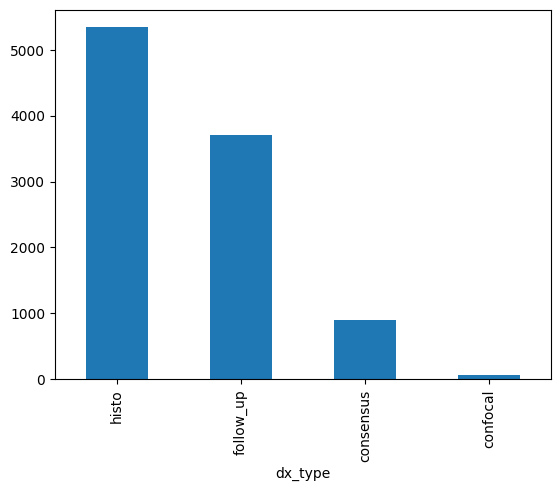

In [7]:
df['dx_type'].value_counts().plot(kind='bar')

<Axes: xlabel='localization'>

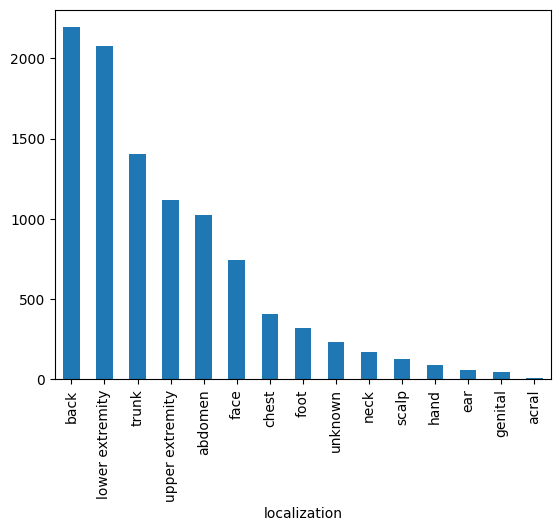

In [8]:
df['localization'].value_counts().plot(kind='bar')

<Axes: >

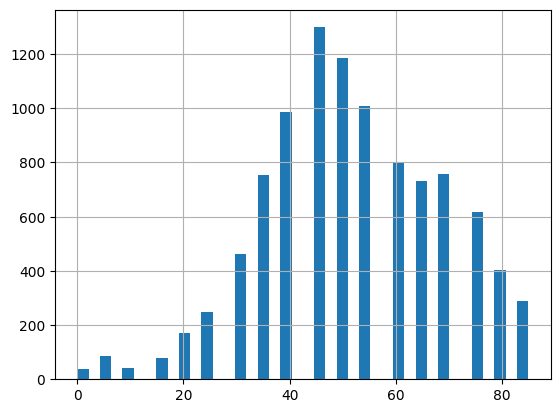

In [9]:
df['age'].hist(bins=40)

<Axes: xlabel='sex'>

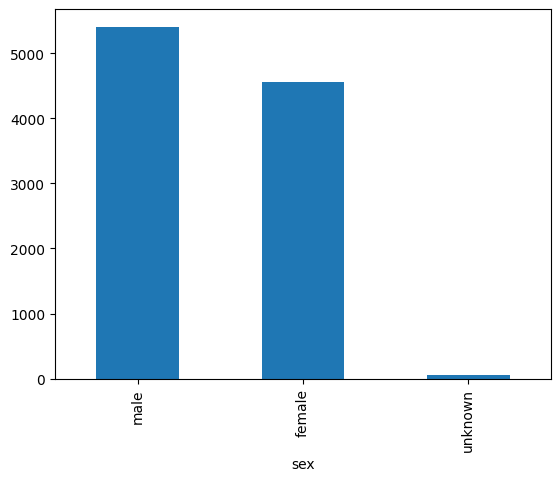

In [10]:
df['sex'].value_counts().plot(kind='bar')

<Axes: xlabel='age', ylabel='cell_type_idx'>

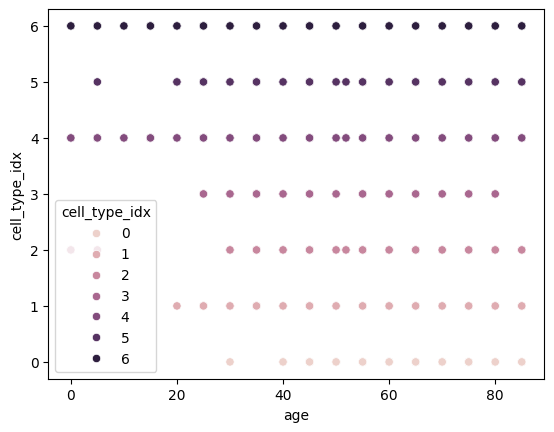

In [21]:
# visualize distribution of cancer types for each age group
sns.scatterplot(x='age',y='cell_type_idx',data=df, hue='cell_type_idx')

DATA CLEANING 

In [22]:
df.isnull().sum()
df['age'].fillna((df['age'].mean()), inplace=True)


C:\Users\giamb\AppData\Local\Temp\ipykernel_18212\4229294920.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna((df['age'].mean()), inplace=True)


In [23]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

0


TRAIN TEST SPLIT

In [14]:
# split into training and testing set 
y = df["cell_type_idx"]
x = df["path"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(f"X_train shape: {x_train.shape}")
print(f"X_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (8012,)
X_test shape: (2003,)
y_train shape: (8012,)
y_test shape: (2003,)


MODEL I: CNN

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

# Configuration parameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = df['cell_type'].nunique()  # Should be 7 for our dataset

# Reconstruct training and testing dataframes from the earlier split
train_df = pd.DataFrame({'path': x_train, 'cell_type_idx': y_train})
test_df = pd.DataFrame({'path': x_test, 'cell_type_idx': y_test})

# Create ImageDataGenerators for training and validation (testing)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='cell_type_idx',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='cell_type_idx',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False
)

# -----------------------------
# Model 1: Simple Custom CNN
# -----------------------------
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Simple CNN Summary:")
model1.summary()

history1 = model1.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

# ------------------------------------------
# Model 2: Transfer Learning with MobileNetV2
# ------------------------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the pre-trained layers

model2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("MobileNetV2-based Model Summary:")
model2.summary()

history2 = model2.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

# ------------------------------------------
# Model 3: Transfer Learning with ResNet50
# ------------------------------------------
base_model_resnet = tf.keras.applications.ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model_resnet.trainable = False

model3 = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("ResNet50-based Model Summary:")
model3.summary()

history3 = model3.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)


Found 8012 validated image filenames.
Found 2003 validated image filenames.
Simple CNN Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
129/251 ━━━━━━━━━━━━━━━━━━━━ 4:17 2s/step - accuracy: 0.6353 - loss: 1.4210

KeyboardInterrupt: 